# Przetwarzanie Języka Naturalnego/ Natural Language Processing
### Project
### Wykonany przez studentów Politechniki Krakowskiej, wydziału Informatyki i Telekomunikacji
* David Burchakov
* Mikhail Ermolaev
  

# Narzędzie do identyfikacji podobnych tekstów

> 13. Proszę napisać narzędzie do identyfikacji podobnych tekstów (znaczenie, a nie tekst) i
> przetestować na zestawie danych:
> Literatura:
> https://www.kaggle.com/c/quora-question-pairs/overview
>

## TOC: <a class="anchor" id="TOC" name="TOC"></a>
* [Preface](#preface)
* [Pre-Processing](#second-bullet)
  * [Remove Stopwords](#pre1)
  * [Expand Contractions](#pre2)
  * [Remove possessive endings](#pre3)
  * [Lemmatization](#pre4)
  * [Remove special characters](#special-char-r)
  * [Preserve capitalizations](#preserve-cap)
  * [Capitalize Named Entities](#cap)
  * [All together](#pre-together)
  * [Tokenization](#token)
* [Find similar movies from the dataset](#similar)
  * [LSA and PCA without pre-processing](#similar_without_preproc)
  * [LSA and PCA with pre-processing](#similar_with_preproc)
  * [Word2Vec with pre-processing](#word2Vec_with_preproc)


* [Identify similarities between two sentences](#between)
  * [Advanced methods for text processing](#advanced)
      * [Word Embedding Methods](#embedding)
          * [Gensim](#gensim)
          * [FastText](#fasttext)
          * [GloVe](#glove)
* [Natural Language Generation](#NN)
* [Similar sentence generation](#NLG)

# Preface <a class="anchor" id="preface" name="preface"></a>


# **Pre-processing** <a class="anchor" id="second-bullet" name="second-bullet"></a>

### **Remove stopwords** <a class="anchor" id="pre1" name="pre1"></a>

In [ ]:
%%capture
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

# Remove negative words like "not" from the stop words list
negative_words = {'not'}
stop_words = stop_words - negative_words

def remove_stopwords(text):
    words = word_tokenize(text)

    # Ensure that negative words are not removed
    filtered_words = [word for word in words if word.lower() not in stop_words]

    filtered_text = ' '.join(filtered_words)

    return filtered_text


# Example usage:
example_text = "This is a Sample sentence, showing off the stop words filtration. Does not like"
filtered_example = remove_stopwords(example_text)
print(filtered_example)

Sample sentence , showing stop words filtration . not like


### **Expand contractions** <a class="anchor" id="pre2" name="pre2"></a>

In [ ]:
%%capture
!pip install contractions

In [ ]:
import spacy
import contractions

nlp = spacy.load("en_core_web_sm")

def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

print("don't   aren't   won't     doesn't")
print(expand_contractions("don't  aren't  won't  doesn't"))

/usr/local/lib/python3.10/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.6.0) was trained with spaCy v3.6.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


don't   aren't   won't     doesn't
do not  are not  will not  does not


### **Remove possessive endings that are not contractions** <a class="anchor" id="pre3" name="pre3"></a>
e.g century's => century

In [ ]:
import re

def remove_possessive_endings(text):
    text = re.sub(r"'s\b", "", text)
    return text

text = "the rock is destined to be the 21st century's new and that he is going to make a splash \
even greater than arnold schwarzenegger , jean-claud van damme or steven segal ."
remove_possessive_endings(text)

'the rock is destined to be the 21st century new and that he is going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .'

### **Lemmatization** <a class="anchor" id="pre4" name="pre4"></a>
Lemmatize the sentence, keeping in mind dashed words like fast-forward, self-explanatory - will consider dashed words as a single token

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

def lemmatize(sentence):
    # Parse the sentence using spaCy
    doc = nlp(sentence)

    # Initialize an empty list to store the lemmatized tokens
    lemmatized_tokens = []

    # Iterate over each token in the document
    for token in doc:
        # Check if the token is part of a hyphenated word
        if token.i > 0 and (doc[token.i - 1].text == '-' or token.text == '-'):
            # Skip the current token as it's part of a hyphenated word
            continue
        elif token.i < len(doc) - 1 and (doc[token.i + 1].text == '-' or token.text == '-'):
            # If the token is the first part of a hyphenated word, concatenate it with the next part
            hyphenated_word = token.text + doc[token.i + 1].text + doc[token.i + 2].text
            # Append the hyphenated word to the list without lemmatizing
            lemmatized_tokens.append(hyphenated_word)
        else:
            # If the token is a regular word, lemmatize it and append to the list
            lemmatized_tokens.append(token.lemma_)

    # Join the lemmatized tokens back into a string
    lemmatized = " ".join(lemmatized_tokens)

    return lemmatized

# Example usage
sentence = "I need to fast-forward through the boring parts of this movie. Finally"
lemmatized_sentence = lemmatize(sentence)
print(lemmatized_sentence)


I need to fast-forward through the boring part of this movie . finally


### **Remove special characters** <a class="anchor" id="special-char-r" name="special-char-r"></a>
Removing special characters is not always relevant.

But for text classification characters like ! and ? are not very useful

Punctuation and characters are more important for chatbots and NLG

In [ ]:
import re

def remove_special_chars(text):
    # Remove HTML tags
    no_html = re.sub(r'<[^>]+>', '', text)

    # Keep ?, !, ., ,, -, : and numbers; remove other special characters
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s\?\!\-\:\.,]', '', no_html)

    return cleaned_text

# Example usage
example_text = "Hello! This is a test text with HTML: <br> and some[]{}<html> self-explanatory (special) characters, including numbers 123 and symbols{}[]()/\\."
cleaned_text = remove_special_chars(example_text)
print(cleaned_text)

Hello! This is a test text with HTML:  and some self-explanatory special characters, including numbers 123 and symbols.


## **Handle Capitalization**
<a class="anchor" id="preserve-cap" name="preserve-cap"></a>
##### Handle capitalization using spacy. Words that mean names, companies, cities, etc will stay capitalized.
##### Capitalized words at the beginning of the sentence will be lowercased

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

def preserve_capitalization(text):
    doc = nlp(text)
    new_text = []
    for token in doc:
        if token.ent_type_:
            new_text.append(token.text)
        else:
            new_text.append(token.text.lower())
    return ' '.join(new_text)

text = "Apple Inc. is based in Cupertino. I love New York. Century Apples. the rock is destined to be the 21st century's new conan and \
that he's going to make a splash even Greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal . "
processed_text = preserve_capitalization(text)
print(processed_text)

Apple Inc. is based in Cupertino . i love New York . Century Apples . the rock is destined to be the 21st century 's new conan and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean - Claud Van Damme or Steven Segal .


## **Capitalize named entities**
<a class="anchor" id="cap" name="cap"></a>

Capitalize each word of a named-entity

e.g arnold schwarzenegger => Arnold Schwarzenegger, NOT Arnold schwarzenegger

In [ ]:
%%capture
!python -m spacy download xx_ent_wiki_sm

# Load the multi-language NER model
nlp = spacy.load("xx_ent_wiki_sm")

In [ ]:
import spacy

"""
Not recognizes all Named Entities correctly.
Should be improved or skipped.
"""
def capitalize_named_entities(text):
    doc = nlp(text)
    new_text = ""
    last_idx = 0

    for ent in doc.ents:
        new_text += text[last_idx:ent.start_char]

        # Split the entity text by space and capitalize each word
        entity_words = ent.text.split()
        capitalized_entity = ' '.join(word.capitalize() for word in entity_words)

        # Add the capitalized entity text
        new_text += capitalized_entity

        last_idx = ent.end_char

    # Add the remainder of the text after the last entity
    new_text += text[last_idx:]

    return new_text

text = "apple inc. warsaw, london, prague, arnold schwarzenegger, jean-claud van damme or steven segal. I have an apple iphone"
# text = dataset.iloc[0].Review
capitalized_text = capitalize_named_entities(text)
print(capitalized_text)


Apple Inc. Warsaw, London, Prague, Arnold Schwarzenegger, Jean-claud Van Damme or steven segal. I have an Apple Iphone


In [ ]:
import spacy

# Load the spaCy model with NER capabilities
nlp = spacy.load("en_core_web_sm")

def capitalize_named_entities(text):
    # Process the text with spaCy
    doc = nlp(text)

    # Iterate over the identified entities
    for ent in doc.ents:
        # Capitalize each entity in the text
        text = text.replace(ent.text, ent.text.title())

    return text

# Example usage
text = "the rock is destined to be the 21st century's new 'conan' and that he's going to make a splash even greater \
than arnold schwarzenegger, jean-claud van damme or steven segal. apple. I like apples. I eat an apple. I have an apple iphone"
capitalized_text = capitalize_named_entities(text)
print(capitalized_text)


the rock is destined to be The 21St Century'S new 'conan' and that he's going to make a splash even greater than arnold schwarzenegger, Jean-claud van damme or steven segal. apple. I like apples. I eat an apple. I have an apple iphone


## **Pre-processing all together** <a class="anchor" id="pre-together" name="pre-together"></a>

[go to TOC](#TOC)

In [ ]:
def process_sentence(sentence):
  try:
    contracted = expand_contractions(sentence)
    stop = remove_stopwords(contracted)
    possessive = remove_possessive_endings(stop)
    lemma = lemmatize(possessive)
    capitalized = preserve_capitalization(lemma)
    capital = capitalize_named_entities(capitalized)
    special = remove_special_chars(capital)

    return special
  except Exception as e:
    print(f"Error processing sentence {sentence}: {e}")

sentence = "This movie was truly amazing and had a great story."
processed_sentence = process_sentence(sentence)
print(processed_sentence)

movie truly amazing great story .


In [ ]:
import pandas as pd
import time

start_time = time.time()




dataset_clean = []
for i in range(len(dataset)):
    try:
        item = dataset.iloc[i]
        contracted = expand_contractions(item.Review)
        stop = remove_stopwords(contracted)
        possessive = remove_possessive_endings(stop)
        lemma = lemmatize(possessive)
        capitalized = preserve_capitalization(lemma)
        capital = capitalize_named_entities(capitalized)
        special = remove_special_chars(capital)

        entry = {'Review': special, 'Freshness': item.Freshness}
        dataset_clean.append(entry)
    except Exception as e:
        print(f"Error processing row {i}: {e}")

dataset_clean = pd.DataFrame(dataset_clean)


end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

NameError: ignored

### **Tokenization** <a class="anchor" id="token" name="token"></a>
For Movie Review data the casual tokenizer from NLTK is chosen.

Additionally, it removes repeated chatacters  

In [ ]:
from nltk.tokenize.casual import casual_tokenize
message = """    RT @TJMonticello Best day everrrrrrr at Monticello.\
Awesommmmmmeeeeeeee day :*)"""
message = """RT @TJMonticello Best day ever at Monticello.\
Awesome day :*)"""
print(message)
print()
print(casual_tokenize(message, reduce_len=True, strip_handles=True))

RT @TJMonticello Best day ever at Monticello.Awesome day :*)

['RT', 'Best', 'day', 'ever', 'at', 'Monticello.Awesome', 'day', ':*)']


# Similar Movies <a class="anchor" id="similar" name="similar"></a>

Here's an example of finding the most similar films from the database using LSA and PCA.
First, we import all the necessary libraries and also read data from the file.

In [ ]:
!pip install contractions
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.8 MB/s eta 0:00:00


In [ ]:
## LSA, PCA, LSA & PCA, Word2Vec
# all necessary imports
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.tokenize import casual_tokenize
import nltk
import contractions
import re
import spacy
from gensim.models import Word2Vec
import numpy as np
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
nltk.download('punkt')
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot a bar chart for movie similarities without x-axis labels
def plot_similarity_chart_no_labels(similarities, method_name):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=similarities.index, y=similarities.values, palette="viridis")
    plt.title(f"Similarity Scores using {method_name}")
    plt.xlabel("")
    plt.ylabel("Similarity Score")
    plt.xticks([])  # Remove x-axis labels
    plt.tight_layout()
    # Print the ID at the bottom in black
    for i, title in enumerate(similarities.index, start=1):
        if i % 100 == 0:
            plt.text(i - 1, 0, str(i), ha='center', va='bottom', rotation=45, color='black', fontsize=8)

    plt.show()


# Read the dataset
df = pd.read_csv('tmdb_5000_movies.csv')
df = df[['title', 'tagline', 'overview', 'genres', 'popularity']]
df.tagline.fillna(value="", inplace=True)
df['description'] = df['tagline'].map(str) + ' ' + df['overview']
# Fill NaN values in the 'overview' column with an empty string
df['overview'].fillna(value='', inplace=True)
df.head(2)

,title,tagline,overview,genres,popularity,description
0,Avatar,Enter the World of Pandora.,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",150.437577,Enter the World of Pandora. In the 22nd centur...
1,Pirates of the Caribbean: At World's End,"At the end of the world, the adventure begins.","Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",139.082615,"At the end of the world, the adventure begins...."


## LSA and PCA methods without pre-processing<a class="anchor" id="similar_without_preproc" name="similar_without_preproc"></a>

Now let's try to find similar films for the first film on the list - Avatar, WITHOUT using pre-processing and see what we'll got.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Similar movies using LSA:
                      title  similarity
0                    Avatar    1.000000
2796  The Prisoner of Zenda    0.956195
1377                Species    0.955670
3815           Major Dundee    0.955369
1817          The Bodyguard    0.945835

Similar movies using PCA:
                      title  similarity
0                    Avatar    1.000000
1377                Species    0.890913
4261                Shalako    0.871700
2796  The Prisoner of Zenda    0.871591
2650    All The Queen's Men    0.870764
Similar movies using both LSA and PCA:
                      title  combined_similarity
0                    Avatar             1.000000
1377                Species             0.923292
2796  The Prisoner of Zenda             0.913893
2650    All The Queen's Men             0.905748
4261                Shalako             0.897803


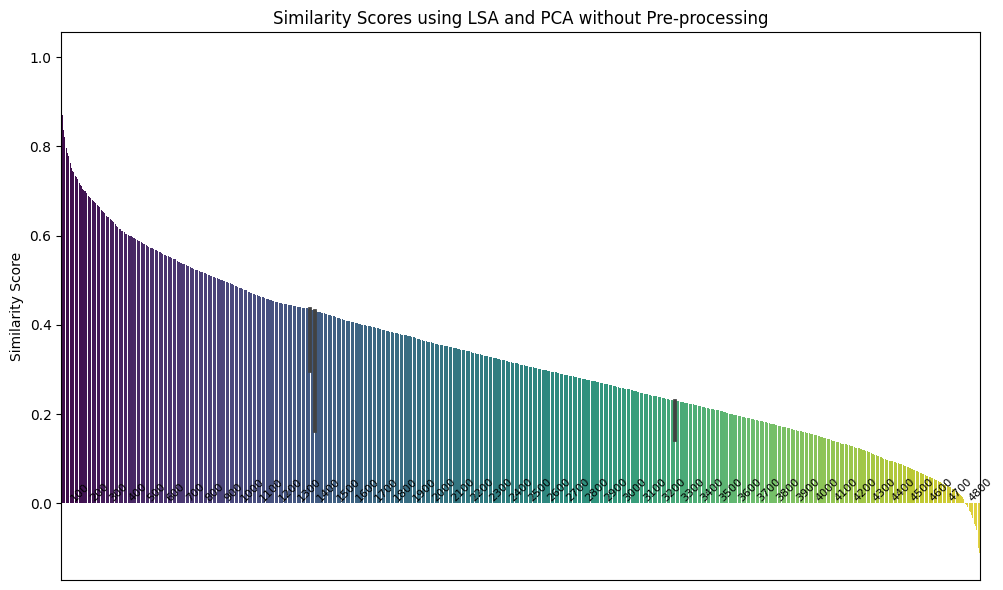

In [ ]:
## LSA, PCA, LSA & PCA WITHOUT pre-processing

# Create TF-IDF matrix
tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=df.overview).toarray()
# Apply LSA using TruncatedSVD
lsa = TruncatedSVD(n_components=16)
lsa_topic_vectors = lsa.fit_transform(tfidf_docs)
# Apply PCA
pca = PCA(n_components=16)
pca_topic_vectors = pca.fit_transform(tfidf_docs)

# Function to find similar movies
def find_similar_movies(movie_index, vectors, method='cosine'):
    similarity_matrix = cosine_similarity([vectors[movie_index]], vectors)
    similar_movies = df[['title', 'overview']].copy()
    similar_movies['similarity'] = similarity_matrix[0]
    similar_movies = similar_movies.sort_values(by='similarity', ascending=False)
    return similar_movies

# Function to find similar movies using both LSA and PCA
def find_similar_movies_LSA_and_PCA(movie_index, lsa_vectors, pca_vectors):
    lsa_similarity_matrix = cosine_similarity([lsa_vectors[movie_index]], lsa_vectors)
    pca_similarity_matrix = cosine_similarity([pca_vectors[movie_index]], pca_vectors)
    # Combine the results by taking the average similarity score
    combined_similarity = (lsa_similarity_matrix + pca_similarity_matrix) / 2
    similar_movies = df[['title', 'overview']].copy()
    similar_movies['combined_similarity'] = combined_similarity[0]
    similar_movies = similar_movies.sort_values(by='combined_similarity', ascending=False)
    return similar_movies

# Choose a movie index to find similar movies
movie_index = 0

# Find similar movies using LSA
similar_movies_lsa = find_similar_movies(movie_index, lsa_topic_vectors)
print("\nSimilar movies using LSA:")
print(similar_movies_lsa[['title', 'similarity']].head(5))

# Find similar movies using PCA
similar_movies_pca = find_similar_movies(movie_index, pca_topic_vectors)
print("\nSimilar movies using PCA:")
print(similar_movies_pca[['title', 'similarity']].head(5))

# Find similar movies using both LSA and PCA
similar_movies_combined = find_similar_movies_LSA_and_PCA(movie_index, lsa_topic_vectors, pca_topic_vectors)
print("Similar movies using both LSA and PCA:")
print(similar_movies_combined[['title', 'combined_similarity']].head(5))

all_combined_similarities = similar_movies_combined[['title', 'combined_similarity']].set_index('title')['combined_similarity']
# Plot the bar chart for both methods without x-axis labels
plot_similarity_chart_no_labels(all_combined_similarities, "LSA and PCA without Pre-processing")

## LSA and PCA methods with pre-processing<a class="anchor" id="similar_with_preproc" name="similar_with_preproc"></a>

This is the result we get using pre-processing:

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Similar movies using LSA:
                      title  similarity
0                    Avatar    1.000000
320         Black Hawk Down    0.975823
157  Exodus: Gods and Kings    0.973134
291       National Treasure    0.948996
768                  Priest    0.939105

Similar movies using PCA:
                              title  similarity
0                            Avatar    1.000000
291               National Treasure    0.918275
3568   20,000 Leagues Under the Sea    0.898312
1367  Star Trek: The Motion Picture    0.888919
1101                     Foodfight!    0.877429
Similar movies using both LSA and PCA:
                             title  combined_similarity
0                           Avatar             1.000000
291              National Treasure             0.933636
320                Black Hawk Down             0.917675
3568  20,000 Leagues Under the Sea             0.901894
2899            Legend of a Rabbit             0.898812


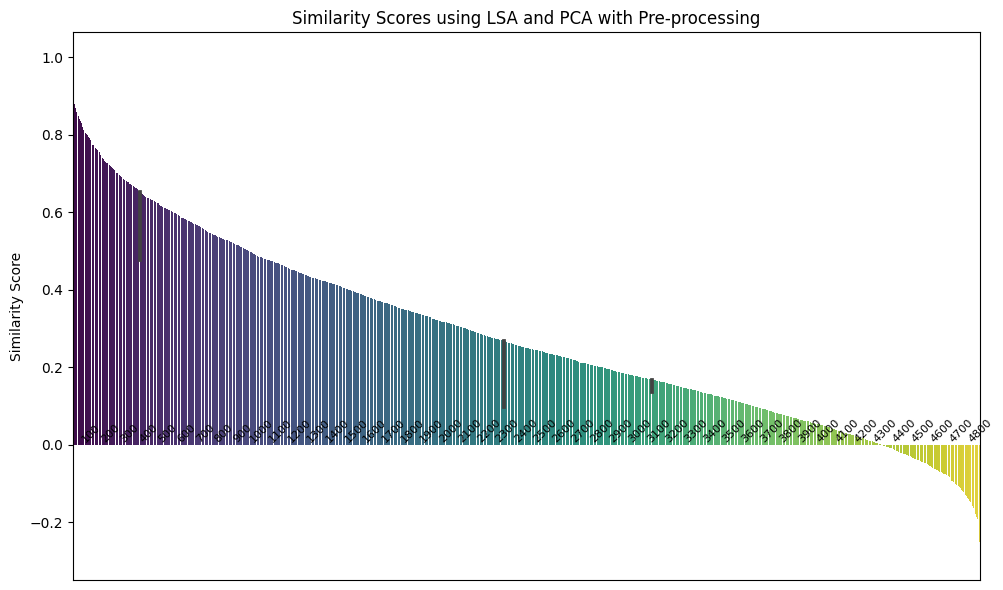

In [ ]:
## LSA, PCA, LSA & PCA WITH pre-processing
stop_words = set(stopwords.words('english'))

def remove_possessive_endings(text):
    text = re.sub(r"'s\b", "", text)
    return text

def lemmatize(text):
    doc = nlp(text)
    # Lemmatize each token and join them back into a string
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    return lemmatized_text

##                          pre-processing
def process_text(text):
    # Remove possessive endings
    text = remove_possessive_endings(text)

    # Expand contractions
    expanded_text = contractions.fix(text)

    # Remove stopwords
    words = casual_tokenize(expanded_text)
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]

     # Lemmatize the text
    lemmatized_text = lemmatize(" ".join(filtered_words))
    return lemmatized_text


# Apply the process_text function to the 'overview' column
df['processed_overview'] = df['overview'].apply(process_text)


# Create TF-IDF matrix
tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=df.processed_overview).toarray()
# Apply LSA using TruncatedSVD
lsa = TruncatedSVD(n_components=16)
lsa_topic_vectors = lsa.fit_transform(tfidf_docs)
# Apply PCA
pca = PCA(n_components=16)
pca_topic_vectors = pca.fit_transform(tfidf_docs)

# Choose a movie index to find similar movies
movie_index = 0

# Find similar movies using LSA
similar_movies_lsa = find_similar_movies(movie_index, lsa_topic_vectors)
print("\nSimilar movies using LSA:")
print(similar_movies_lsa[['title', 'similarity']].head(5))

# Find similar movies using PCA
similar_movies_pca = find_similar_movies(movie_index, pca_topic_vectors)
print("\nSimilar movies using PCA:")
print(similar_movies_pca[['title', 'similarity']].head(5))

# Find similar movies using both LSA and PCA
similar_movies_combined = find_similar_movies_LSA_and_PCA(movie_index, lsa_topic_vectors, pca_topic_vectors)
print("Similar movies using both LSA and PCA:")
print(similar_movies_combined[['title', 'combined_similarity']].head(5))

all_combined_similarities = similar_movies_combined[['title', 'combined_similarity']].set_index('title')['combined_similarity']
plot_similarity_chart_no_labels(all_combined_similarities, "LSA and PCA with Pre-processing")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Similar movies using LSA:
                       title  similarity
0                     Avatar    1.000000
1510                    1941    0.965534
157   Exodus: Gods and Kings    0.951718
320          Black Hawk Down    0.951314
529         Tears of the Sun    0.949801


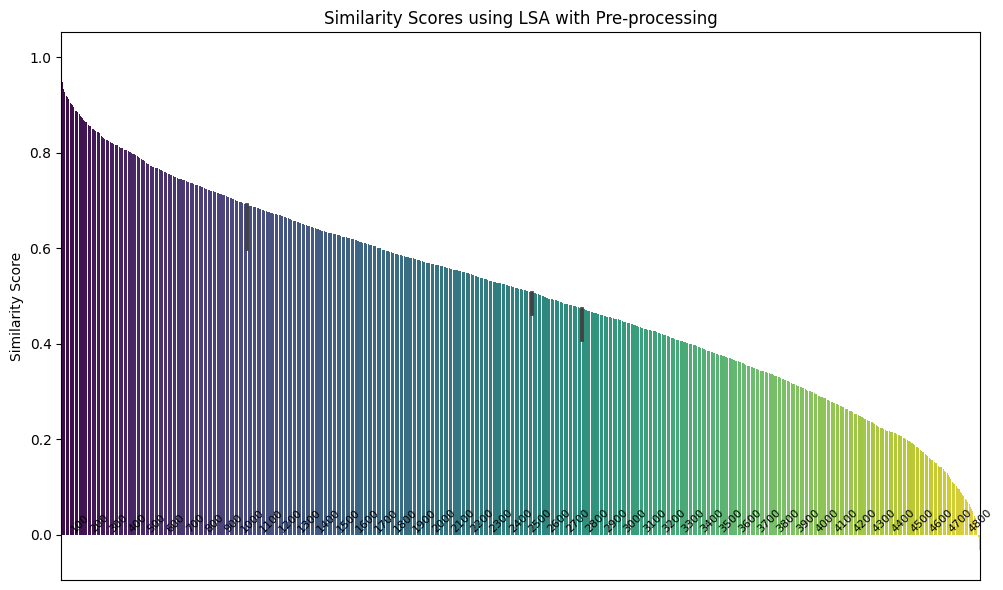

In [ ]:
## LSA WITH pre-processing
stop_words = set(stopwords.words('english'))

def remove_possessive_endings(text):
    text = re.sub(r"'s\b", "", text)
    return text

def lemmatize(text):
    doc = nlp(text)
    # Lemmatize each token and join them back into a string
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    return lemmatized_text

##                          pre-processing
def process_text(text):
    # Remove possessive endings
    text = remove_possessive_endings(text)

    # Expand contractions
    expanded_text = contractions.fix(text)

    # Remove stopwords
    words = casual_tokenize(expanded_text)
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]

     # Lemmatize the text
    lemmatized_text = lemmatize(" ".join(filtered_words))
    return lemmatized_text


# Apply the process_text function to the 'overview' column
df['processed_overview'] = df['overview'].apply(process_text)


# Create TF-IDF matrix
tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=df.processed_overview).toarray()
# Apply LSA using TruncatedSVD
lsa = TruncatedSVD(n_components=16)
lsa_topic_vectors = lsa.fit_transform(tfidf_docs)
# Apply PCA
pca = PCA(n_components=16)
pca_topic_vectors = pca.fit_transform(tfidf_docs)

# Choose a movie index to find similar movies
movie_index = 0

# Find similar movies using LSA
similar_movies_lsa = find_similar_movies(movie_index, lsa_topic_vectors)
print("\nSimilar movies using LSA:")
print(similar_movies_lsa[['title', 'similarity']].head(5))

lsa_similarity = similar_movies_lsa[['title', 'similarity']].set_index('title')['similarity']
plot_similarity_chart_no_labels(lsa_similarity, "LSA with Pre-processing")

## Word2Vec method with pre-processing <a class="anchor" id="word2Vec_with_preproc" name="word2Vec_with_preproc"></a>

Using previous code for pre-processing let's try Word2Vec method this time and check the results:

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Similar movies using Word2Vec:
                           title  similarity
0                         Avatar    1.000000
1790  O Brother, Where Art Thou?    0.982670
634                   The Matrix    0.982631
1643             Howard the Duck    0.982597
3394                    Freeheld    0.982178


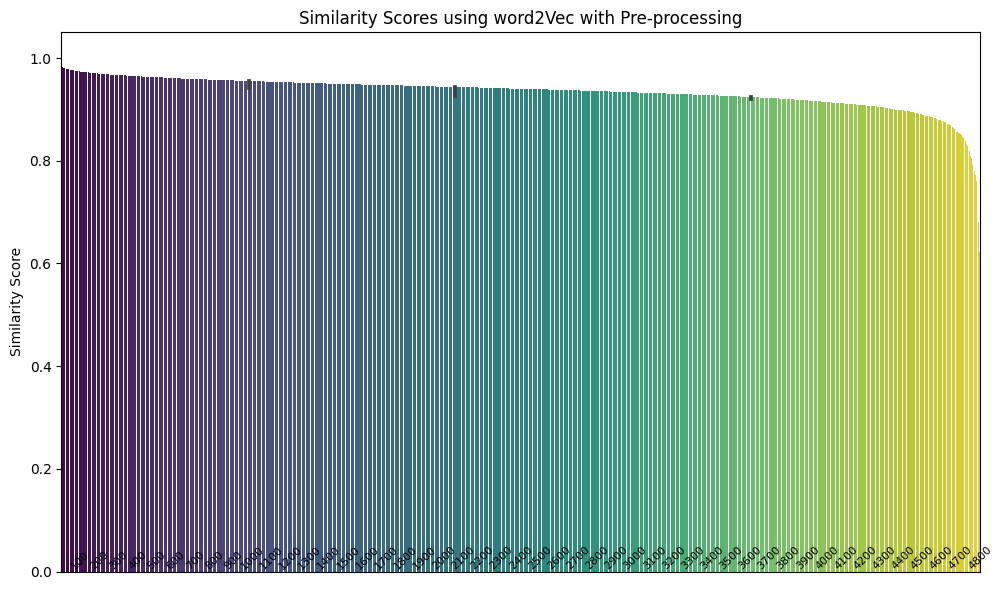

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import casual_tokenize
from gensim.models import Word2Vec
stop_words = set(stopwords.words('english'))

def remove_possessive_endings(text):
    text = re.sub(r"'s\b", "", text)
    return text

def lemmatize(text):
    doc = nlp(text)
    # Lemmatize each token and join them back into a string
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    return lemmatized_text

##                          pre-processing
def process_text(text):
    # Remove possessive endings
    text = remove_possessive_endings(text)

    # Expand contractions
    expanded_text = contractions.fix(text)

    # Remove stopwords
    words = casual_tokenize(expanded_text)
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]

     # Lemmatize the text
    lemmatized_text = lemmatize(" ".join(filtered_words))
    return lemmatized_text


# Apply the process_text function to the 'overview' column
overview = df['overview'].apply(process_text)
overview = df.overview.apply(casual_tokenize)

# Train Word2Vec model
word2vec_model = Word2Vec(
    window=5,
    min_count=2,
    workers=4
)
word2vec_model.build_vocab(overview, progress_per=1000)
word2vec_model.train(overview, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

# Create TF-IDF matrix
tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=df.overview).toarray()

# Apply LSA using TruncatedSVD
lsa = TruncatedSVD(n_components=16)
lsa_topic_vectors = lsa.fit_transform(tfidf_docs)

# Apply PCA
pca = PCA(n_components=16)
pca_topic_vectors = pca.fit_transform(tfidf_docs)

# Function to find similar movies using Word2Vec
def find_similar_movies_word2vec(movie_index, model, df):
    # Get the vector representation of the movie
    movie_vector = model.wv[movie_index]

    # Calculate cosine similarity between the movie and all others
    similarity_scores = cosine_similarity([movie_vector], model.wv[df.index])

    # Create a DataFrame with movie indices and similarity scores
    similar_movies = df[['title', 'overview']].copy()
    similar_movies['similarity'] = similarity_scores[0]

    # Sort the DataFrame by similarity in descending order
    similar_movies = similar_movies.sort_values(by='similarity', ascending=False)

    return similar_movies

# Choose a movie index to find similar movies
movie_index = df.index[0]

# Find similar movies using Word2Vec
similar_movies_word2vec = find_similar_movies_word2vec(movie_index, word2vec_model, df)
print("\nSimilar movies using Word2Vec:")
print(similar_movies_word2vec[['title', 'similarity']].head(5))


x = similar_movies_word2vec[['title', 'similarity']].set_index('title')['similarity']
plot_similarity_chart_no_labels(x, "word2Vec with Pre-processing")

several examples using word2Vec:

In [ ]:
#similarity of Avatar and Pirates of the Caribbean: At World's End
word2vec_model.wv.similarity(w1=0,w2=1)

0.7511802

In [ ]:
# similarity of Pirates of the Caribbean: At World's End and The Matrix
word2vec_model.wv.similarity(w1=1,w2=634)

0.8210188

----------------------------------------------------
other examples of finding best mathces in movie database:
----------------------------------------------------

In [ ]:
def movie_recommender(movie_title, movies=movies_list, doc_sims=doc_sim_df):
 movie_idx = np.where(movies == movie_title)[0][0]
 movie_similarities = doc_sims.iloc[movie_idx].values
 # get top 5 similar movie IDs
 similar_movie_idxs = np.argsort(-movie_similarities)[1:6]
 # get top 5 movies
 similar_movies = movies[similar_movie_idxs]
 return similar_movies

In [ ]:
pop_movies = df.sort_values(by='popularity', ascending=False)
pop_movies.head()

,title,tagline,overview,genres,popularity,description
546,Minions,"Before Gru, they had a history of bad bosses","Minions Stuart, Kevin and Bob are recruited by...","[{""id"": 10751, ""name"": ""Family""}, {""id"": 16, ""...",875.581305,"Before Gru, they had a history of bad bosses M..."
95,Interstellar,Mankind was born on Earth. It was never meant ...,Interstellar chronicles the adventures of a gr...,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 18, ""...",724.247784,Mankind was born on Earth. It was never meant ...
788,Deadpool,Witness the beginning of a happy ending,Deadpool tells the origin story of former Spec...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",514.569956,Witness the beginning of a happy ending Deadpo...
94,Guardians of the Galaxy,All heroes start somewhere.,"Light years from Earth, 26 years after being a...","[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...",481.098624,All heroes start somewhere. Light years from E...
127,Mad Max: Fury Road,What a Lovely Day.,An apocalyptic story set in the furthest reach...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",434.278564,What a Lovely Day. An apocalyptic story set in...


In [ ]:
popular_movies = ['Minions', 'Interstellar', 'Deadpool', 'Jurassic World',
'Pirates of the Caribbean: The Curse of the Black Pearl',
'Dawn of the Planet of the Apes', 'The Hunger Games: Mockingjay - Part 1',
'Terminator Genisys', 'Captain America: Civil War', 'The Dark Knight', 'The Martian',
'Batman v Superman: Dawn of Justice', 'Pulp Fiction', 'The Godfather',
'The Shawshank Redemption', 'The Lord of the Rings: The Fellowship of the Ring',
'Harry Potter and the Chamber of Secrets', 'Star Wars',
'The Hobbit: The Battle of the Five Armies', 'Iron Man']

In [ ]:
for movie in popular_movies:
 print('Movie:', movie)
 print('Top 5 recommended Movies:', movie_recommender(movie_title=movie))
 print()

Movie: Minions
Top 5 recommended Movies: ['Despicable Me 2' 'Despicable Me'
 'Teenage Mutant Ninja Turtles: Out of the Shadows' 'Superman'
 'Rise of the Guardians']

Movie: Interstellar
Top 5 recommended Movies: ['Gattaca' 'Space Pirate Captain Harlock' 'Space Cowboys'
 'Starship Troopers' 'Final Destination 2']

Movie: Deadpool
Top 5 recommended Movies: ['Silent Trigger' 'Underworld: Evolution' 'Bronson' 'Shaft' 'Don Jon']

Movie: Jurassic World
Top 5 recommended Movies: ['Jurassic Park' 'The Lost World: Jurassic Park' 'The Nut Job'
 "National Lampoon's Vacation" 'Vacation']

Movie: Pirates of the Caribbean: The Curse of the Black Pearl
Top 5 recommended Movies: ["Pirates of the Caribbean: Dead Man's Chest" 'The Pirate'
 'Pirates of the Caribbean: On Stranger Tides'
 'The Pirates! In an Adventure with Scientists!' 'Joyful Noise']

Movie: Dawn of the Planet of the Apes
Top 5 recommended Movies: ['Battle for the Planet of the Apes' 'Groove' 'The Other End of the Line'
 'Chicago Overcoat

In [ ]:
def movie_top_top_similarity(movies=movies_list, doc_sims=doc_sim_df):
    # counter = 0
    best_movie_1 = ""
    best_movie_2 = ""
    best_sim = 0.0
    for movie in movies:
      movie_idx = np.where(movies == movie)[0][0]
      # get movie similarities
      movie_similarities = doc_sims.iloc[movie_idx].values
      # get top 5 similar movie IDs
      similar_movie_idxs = np.argsort(-movie_similarities)[1:2]
      # get top 5 movies
      similar_movies = movies[similar_movie_idxs]
      s_m = similar_movies[0]
      movie_idx_2 = np.where(movies == s_m)[0][0]
      sim = doc_sims.iloc[movie_idx, movie_idx_2]
      if sim > best_sim:
        best_movie_1 = movie
        best_movie_2 = s_m
        best_sim = sim
    print('Best pair: ', best_movie_1, ' and ', best_movie_2)
    print('with similarity: ', best_sim)




movie_top_top_similarity()

Best pair:  Kung Fu Panda 2  and  Kung Fu Panda
with similarity:  0.5919097235105792


# **Find similarities between two specific sentences**
<a class="anchor" id="between" name="between"></a>
[go up](#TOC)

## **Robust Word2Vec Models with Gensim**
<a class="anchor" id="gensim" name="gensim"></a>
[go to TOC](#TOC)

In [ ]:
import pandas as pd
dataset_clean = pd.read_csv("clean100000.csv")
dataset_clean.head()

,Review,Freshness
0,wilfully offensive and power by a chest - t...,1
1,it would be difficult to imagine material m...,0
2,despite the gusto its star bring to the rol...,0
3,if there be a good idea at the core of this...,0
4,"Gleeson go the Hallmark Channel route , dam...",0


In [ ]:
%%capture
!pip install gensim
!pip install smart_open

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import WordPunctTokenizer
import time
import numpy as np

start_time = time.time()

# Tokenize sentences in the 'Review' column of the corpus
wpt = WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in dataset_clean['Review']]

# Set values for various parameters
feature_size = 100  # Word vector dimensionality
window_context = 30  # Context window size
min_word_count = 1  # Minimum word count
sample = 1e-3  # Downsample setting for frequent words

# Initialize and train the model (this may take some time)
w2v_model = Word2Vec(vector_size=feature_size,
                     window=window_context,
                     min_count=min_word_count,
                     sample=sample,
                     epochs=50)

# Build the vocabulary and train the Word2Vec model
w2v_model.build_vocab(tokenized_corpus)
w2v_model.train(tokenized_corpus, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

# View similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar(search_term, topn=5)]
                 for search_term in ['movie', 'film', 'good', 'bad', 'hollywood', 'hate', 'love', 'budget', 'actor', 'opinion', 'think', 'see']}
                #  for search_term in ['movie', 'film', 'good', 'bad']}



end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

Time taken: 226.4081790447235 seconds


In [ ]:
print(len(dataset_clean))
similar_words

> Let’s also visualize the words of interest and their similar words using their
> embedding vectors after reducing their dimensions to a 2D space with t-SNE
>
> Text Analysis with Python

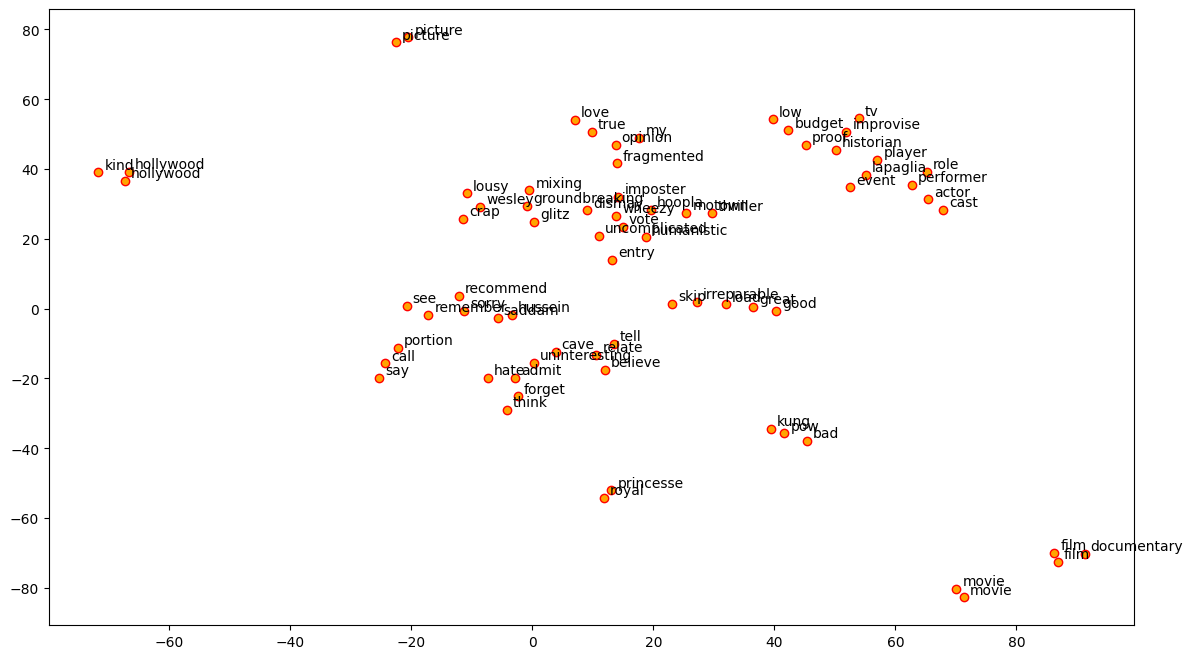

In [ ]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import WordPunctTokenizer
from sklearn.metrics.pairwise import cosine_similarity

# Function to compute cosine similarity using Word2Vec vectors
def word_similarity_analysis(sentence1, sentence2, w2v_model):

    processed_sentence1 = process_sentence(sentence1)
    processed_sentence2 = process_sentence(sentence2)
    tokenizer = WordPunctTokenizer()
    words1 = tokenizer.tokenize(processed_sentence1)
    words2 = tokenizer.tokenize(processed_sentence2)

    similarity_dict = {}

    for word1 in words1:
        vector1 = w2v_model.wv[word1] if word1 in w2v_model.wv else np.zeros(w2v_model.vector_size)
        for word2 in words2:
            vector2 = w2v_model.wv[word2] if word2 in w2v_model.wv else np.zeros(w2v_model.vector_size)
            similarity = cosine_similarity([vector1], [vector2])[0][0]
            similarity_dict[(word1, word2)] = similarity

    sorted_similarities = sorted(similarity_dict.items(), key=lambda item: item[1], reverse=True)

    return sorted_similarities

# Example usage
# Load or train your Word2Vec model here
# w2v_model = Word2Vec.load('your_model_path')

# Analyze similarities
sentence1 = "This movie was truly amazing and had a great story."
sentence2 = "The film was incredibly good and the plot was outstanding."

similarities = word_similarity_analysis(sentence1, sentence2, w2v_model)

# Convert to DataFrame for visualization
unique_words1 = set(pair[0][0] for pair in similarities)
unique_words2 = set(pair[0][1] for pair in similarities)
similarity_df = pd.DataFrame(np.zeros((len(unique_words1), len(unique_words2))),
                             index=sorted(unique_words1),
                             columns=sorted(unique_words2))
for (word1, word2), similarity in similarities:
    similarity_df.at[word1, word2] = similarity

print(similarity_df)


                .      film      good  incredibly  outstanding      plot
.        1.000000  0.049969  0.025652    0.042317    -0.089013  0.112396
amazing -0.094210 -0.082171  0.168613    0.212356     0.199941 -0.121421
great    0.182830 -0.017387  0.424448   -0.115350     0.016520 -0.044540
movie    0.096249  0.594944  0.103938    0.059470     0.078731  0.136007
story    0.103873  0.184527  0.034763   -0.061344    -0.144564  0.362686
truly    0.076266 -0.043420  0.152667    0.306729    -0.018292 -0.067847


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import WordPunctTokenizer

def sentence_similarity(sentence1, sentence2, w2v_model):

    processed_sentence1 = process_sentence(sentence1)
    processed_sentence2 = process_sentence(sentence2)
    tokenizer = WordPunctTokenizer()

    # Tokenize sentences
    words1 = tokenizer.tokenize(processed_sentence1)
    words2 = tokenizer.tokenize(processed_sentence2)
    print(words1)
    print(words2)

    # Compute average vector for each sentence
    vector1 = np.mean([w2v_model.wv[word] for word in words1 if word in w2v_model.wv] or [np.zeros(w2v_model.vector_size)], axis=0)
    vector2 = np.mean([w2v_model.wv[word] for word in words2 if word in w2v_model.wv] or [np.zeros(w2v_model.vector_size)], axis=0)

    # Compute cosine similarity and convert it to percentage
    similarity = cosine_similarity([vector1], [vector2])[0][0]
    return (similarity + 1) / 2 * 100

# Example usage
sentence1 = "This movie was truly amazing and had a great story."
sentence2 = "The film was incredibly good and the plot was outstanding."

# Assuming w2v_model is your Word2Vec model
similarity_percentage = sentence_similarity(sentence1, sentence2, w2v_model)
print(f"The similarity between the sentences is: {similarity_percentage:.2f}%")


['movie', 'truly', 'amazing', 'great', 'story', '.']
['film', 'incredibly', 'good', 'plot', 'outstanding', '.']
The similarity between the sentences is: 76.09%


In [ ]:
# input_sentence = "This movie was truly amazing and had a great story."
input_sentence = "I hated this story. The director is a bad person"
tokenized_input = wpt.tokenize(input_sentence)

similar_words_input = {word: w2v_model.wv.most_similar(word, topn=1)[0][0] for word in tokenized_input if word in w2v_model.wv}

print(similar_words_input)

new_sentence = ' '.join([similar_words_input.get(word, word) for word in tokenized_input])

print(input_sentence)
print(new_sentence)

## **GloVe** <a class="anchor" id="glove" name="glove"></a>
[go to top](#TOC)

In [ ]:
# load dataset if not loaded
from google.colab import files
uploaded = files.upload()

import pandas as pd
import io

dataset_clean = pd.read_csv(io.BytesIO(uploaded['clean100000.csv']))

Saving clean100000.csv to clean100000.csv


In [ ]:
%%capture
!pip install -U spacy
!python -m spacy download en_core_web_lg

In [ ]:
import spacy

nlp = spacy.load('en_core_web_lg') # includes word vectors based on the GloVe model
total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 514157


In [ ]:
import numpy as np
import time

start_time = time.time()

unique_words = set()
for sentence in dataset_clean['Review']:
    words = sentence.split()
    unique_words.update(words)

len(unique_words)
unique_words = list(unique_words)
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
words_df = pd.DataFrame(word_glove_vectors, index=unique_words)
words_df

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

Time taken: 475.9674301147461 seconds


### **Find and Analyse Similar words**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

word_to_vec = dict(zip(unique_words, word_glove_vectors))

def find_closest_words(word, word_to_vec):
    if word not in word_to_vec:
        return "Word not in vocabulary."

    # Compute similarity between 'word' and all other words in the vocabulary
    word_vec = word_to_vec[word].reshape(1, -1)
    similarities = {other_word: cosine_similarity(word_vec, other_vec.reshape(1, -1))[0][0]
                    for other_word, other_vec in word_to_vec.items() if other_word != word}

    # Sort words by similarity
    closest_words = sorted(similarities.items(), key=lambda item: item[1], reverse=True)

    return closest_words

# Find the top 5 words closest
for word in ['movie', 'film', 'good', 'bad', 'hollywood', 'hate', 'love', 'budget', 'actor', 'opinion', 'think', 'see']:
# for word in ['movie']:
    closest = find_closest_words(word, word_to_vec)
    print(f"{word}: {closest[:5]}")



movie: [('moviegoer', 0.8596261), ('film', 0.8332769), ('filmy', 0.8014005), ('film-', 0.79649806), ('moviemaker', 0.7779017)]
film: [('film-', 0.93278134), ('filmy', 0.9278247), ('filmic', 0.86514866), ('filme', 0.85421216), ('films', 0.8486484)]
good: [('great', 0.75513047), ('bad', 0.73918885), ('decent', 0.72651505), ('terrific', 0.71511525), ('excellent', 0.69051963)]
bad: [('good', 0.73918885), ('horrible', 0.6745009), ('terrible', 0.66804695), ('nasty', 0.6006269), ('awful', 0.5879264)]
hollywood: [('bollywood', 0.91668683), ('Tollywood', 0.85822594), ('Dollywood', 0.8109392), ('Hollywood', 0.8064641), ('Bollywood', 0.77994925)]
hate: [('hateful', 0.7265867), ('loathe', 0.6639591), ('despise', 0.6581539), ('dislike', 0.6406129), ('stupid', 0.6154527)]
love: [('lovesick', 0.76579475), ('lovefest', 0.7650283), ('lovelorn', 0.7560156), ('lovey', 0.74834085), ('loves', 0.74749565)]
budget: [('budgetary', 0.8245003), ('expenditure', 0.71433854), ('budge', 0.6853767), ('fiscal', 0.637

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

terms_of_interest = ['movie', 'film', 'good', 'bad', 'hate', 'love', 'actor', 'opinion', 'think', 'see']
# terms_of_interest = ['movie']
similar_words = {term: [item[0] for item in find_closest_words(term, word_to_vec)[:3]] for term in terms_of_interest}

# Flatten the list of words to ensure each word is only represented once
words = sum([[k] + v for k, v in similar_words.items()], [])
unique_words_for_tsne = list(set(words))  # Remove duplicates to avoid redundant computation

In [ ]:
print(similar_words)
print(words)
print(unique_words_for_tsne)

{'movie': ['moviegoer', 'film', 'filmy'], 'film': ['film-', 'filmy', 'filmic'], 'good': ['great', 'bad', 'decent'], 'bad': ['good', 'horrible', 'terrible'], 'hate': ['hateful', 'loathe', 'despise'], 'love': ['lovesick', 'lovefest', 'lovelorn'], 'actor': ['actress', 'Actor', 'screenwriter'], 'opinion': ['opinionated', 'viewpoint', 'argument'], 'think': ['thinky', 'know', 'believe'], 'see': ['tell', 'find', 'imagine']}
['movie', 'moviegoer', 'film', 'filmy', 'film', 'film-', 'filmy', 'filmic', 'good', 'great', 'bad', 'decent', 'bad', 'good', 'horrible', 'terrible', 'hate', 'hateful', 'loathe', 'despise', 'love', 'lovesick', 'lovefest', 'lovelorn', 'actor', 'actress', 'Actor', 'screenwriter', 'opinion', 'opinionated', 'viewpoint', 'argument', 'think', 'thinky', 'know', 'believe', 'see', 'tell', 'find', 'imagine']
['Actor', 'viewpoint', 'terrible', 'opinionated', 'horrible', 'good', 'film', 'despise', 'bad', 'lovefest', 'decent', 'movie', 'find', 'love', 'tell', 'hateful', 'see', 'thinky',

In [ ]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

wvs = []
for word in unique_words_for_tsne:
    try:
        wvs.append(word_to_vec[word])
    except KeyError:
        print(f"Word '{word}' not in GloVe dictionary.")

wvs = np.array(wvs)


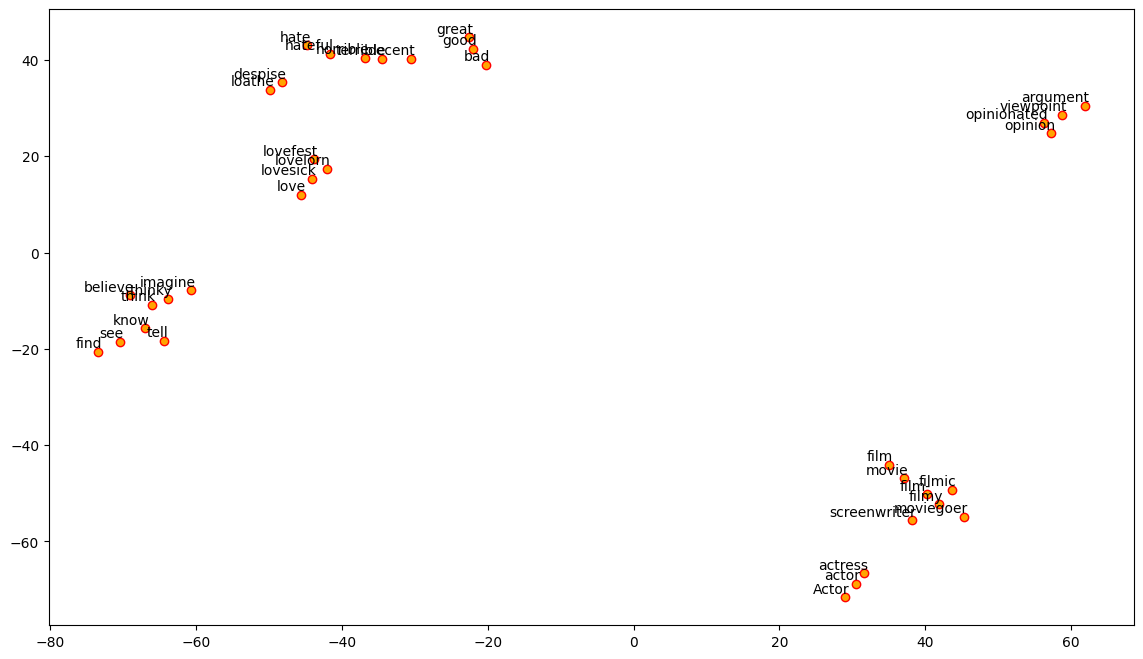

In [ ]:
# Set up and run t-SNE
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)

# Plotting the words
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(unique_words_for_tsne, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(3, 1), textcoords='offset points', ha='right', va='bottom')

plt.show()

### **Analyse similarity of the sentence**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to create a sentence vector by averaging the word vectors of the words in the sentence
def sentence_vector(sentence, word_to_vec):
    words = sentence.split()
    word_vectors = [word_to_vec.get(word, np.zeros((word_glove_vectors.shape[1],))) for word in words]
    sentence_vector = np.mean(word_vectors, axis=0)
    return sentence_vector

# Define two sentences to test the similarity

sentence1 = "This movie was truly amazing and had a great story."
sentence2 = "The film was incredibly good and the plot was outstanding."

# Create vectors for the sentences
processed_sentence1 = process_sentence(sentence1)
processed_sentence2 = process_sentence(sentence2)
vector1 = sentence_vector(processed_sentence1, word_to_vec)
vector2 = sentence_vector(processed_sentence2, word_to_vec)

# Calculate cosine similarity between the two sentence vectors
similarity = cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))[0][0]

# Convert similarity to percentage
similarity_percentage = similarity * 100

# Print out the similarity
print(f"The similarity between the sentences is: {similarity_percentage:.2f}%")


The similarity between the sentences is: 85.60%


Example of dissimmilar texts:

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to create a sentence vector by averaging the word vectors of the words in the sentence
def sentence_vector(sentence, word_to_vec):
    words = sentence.split()
    word_vectors = [word_to_vec.get(word, np.zeros((word_glove_vectors.shape[1],))) for word in words]
    sentence_vector = np.mean(word_vectors, axis=0)
    return sentence_vector

# Define two sentences to test the similarity

sentence1 = "This movie was truly amazing and had a great story."
sentence2 = "My cat is very biting, so I never pick her up"

# Create vectors for the sentences
processed_sentence1 = process_sentence(sentence1)
processed_sentence2 = process_sentence(sentence2)
vector1 = sentence_vector(processed_sentence1, word_to_vec)
vector2 = sentence_vector(processed_sentence2, word_to_vec)

# Calculate cosine similarity between the two sentence vectors
similarity = cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))[0][0]

# Convert similarity to percentage
similarity_percentage = similarity * 100

# Print out the similarity
print(f"The similarity between the sentences is: {similarity_percentage:.2f}%")


The similarity between the sentences is: 51.66%


In [ ]:
# Function to compute cosine similarity between vectors of all words in two sentences
def word_similarity_analysis(sentence1, sentence2, word_to_vec):
    words1 = sentence1.split()
    words2 = sentence2.split()

    # Store similarities in a dictionary
    similarity_dict = {}

    for word1 in words1:
        # Retrieve the vector for word1, or use a zero vector if the word is not in the vocabulary
        vector1 = word_to_vec.get(word1, np.zeros((word_glove_vectors.shape[1],)))
        for word2 in words2:
            # Retrieve the vector for word2, or use a zero vector if the word is not in the vocabulary
            vector2 = word_to_vec.get(word2, np.zeros((word_glove_vectors.shape[1],)))
            # Calculate cosine similarity and store it in the dictionary
            similarity = cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))[0][0]
            similarity_dict[(word1, word2)] = similarity

    # Sort the dictionary by similarity score
    sorted_similarities = sorted(similarity_dict.items(), key=lambda item: item[1], reverse=True)


    return sorted_similarities

similarities = word_similarity_analysis(processed_sentence1, processed_sentence2, word_to_vec)

# similarities
# print(f"Most semantically similar word pair: {most_similar[0]} with a similarity of {most_similar[1]*100:.2f}%")
# print(f"Least semantically similar word pair: {least_similar[0]} with a similarity of {least_similar[1]*100:.2f}%")


In [ ]:
# Extract unique words from both sentences
unique_words1 = set(pair[0][0] for pair in similarities)
unique_words2 = set(pair[0][1] for pair in similarities)

# Create a DataFrame with zeros
similarity_df = pd.DataFrame(np.zeros((len(unique_words1), len(unique_words2))),
                             index=sorted(unique_words1),
                             columns=sorted(unique_words2))

# Populate the DataFrame with the similarity scores
for (word1, word2), similarity in similarities:
    similarity_df.at[word1, word2] = similarity

# Calculate the average similarity score across all word pairs
average_similarity = similarity_df.values.mean()

# Print the similarity matrix and average similarity
print(similarity_df)
print(f"Average Similarity: {average_similarity:.2f}")

                .      film      good  incredibly  outstanding      plot
.        1.000000 -0.009095  0.288674    0.266851     0.326775  0.109322
amazing  0.225753  0.084596  0.590898    0.567639     0.483716  0.051988
great    0.300736  0.082885  0.755130    0.475666     0.592463  0.069649
movie    0.023211  0.833277  0.139775    0.183301     0.016186  0.445783
story    0.096732  0.524190  0.114741    0.297797     0.233712  0.598915
truly    0.173340  0.081420  0.387853    0.652918     0.313164  0.179490
Average Similarity: 0.32


## **Generate a similar sentence** <a class="anchor" id="glove_gen" name="glove_gen"></a>

In [ ]:
def generate_new_sentence(original_sentence, nlp, word_to_vec):
    lemma = lemmatize(original_sentence)
    processed_sentence = nlp(lemma.lower())
    new_sentence = []
    capital = False
    for token in processed_sentence:
        # Replace only if the word is a noun, verb, adjective or adverb
        match token.pos_:
          case "NOUN":
            closest_words = find_closest_words(token.text, word_to_vec)
            for word in closest_words:
              w = nlp(word[0])
              if w[0].pos_ == "NOUN":
                if capital:
                  new_sentence.append(str(word[0]).capitalize())
                  capital = False
                else:
                  new_sentence.append(str(word[0]))
                break

          case "VERB":
            closest_words = find_closest_words(token.text, word_to_vec)
            for word in closest_words:
              w = nlp(word[0])
              if w[0].pos_ == "VERB":
                if capital:
                  new_sentence.append(str(word[0]).capitalize())
                  capital = False
                else:
                  new_sentence.append(str(word[0]))
                break

          case "ADJ":
            closest_words = find_closest_words(token.text, word_to_vec)
            for word in closest_words:
              w = nlp(word[0])
              if w[0].pos_ == "ADJ":
                if capital:
                  new_sentence.append(str(word[0]).capitalize())
                  capital = False
                else:
                  new_sentence.append(str(word[0]))
                break

          case "ADV":
            closest_words = find_closest_words(token.text, word_to_vec)
            for word in closest_words:
              w = nlp(word[0])
              if w[0].pos_ == "ADV":
                if capital:
                  new_sentence.append(str(word[0]).capitalize())
                  capital = False
                else:
                  new_sentence.append(str(word[0]))
                break

          case _:
            if(token.text == "."):
              capital = True
            new_sentence.append(token.text)

    return ' '.join(new_sentence)

# Usage
example_sentence = "The movie is a great plot, the director is a good person. The actors performed very well. Probably the best film of 2014!"
new_sentence = generate_new_sentence(example_sentence, nlp, word_to_vec)
print("Old sentence: ", example_sentence)
print("New sentence: ", new_sentence)


Old sentence:  The movie is a great plot, the director is a good person. The actors performed very well. Probably the best film of 2014!
New sentence:  the moviegoer be a fantastic plotline , the codirector be a great personhood . the Actress performative extremely welly . Improbably the great filmy of 2014 !


## **Similar Text Generation** <a class="anchor" id="NN" name="NN"></a>
[go to top](#TOC)

### **Similar Text Generation** <a class="anchor" id="NLG" name="NLG"></a>

[Model dla generowania podobnych tekstów oparty na seq2seq, TensorFlow](https://www.kaggle.com/code/spleentery/tensor?scriptVersionId=156598884) Runda 1

[Model dla generowania podobnych tekstów oparty na seq2seq, TensorFlow](https://www.kaggle.com/code/spleentery/tensor-improved/notebook?scriptVersionId=155728028) Runda 2